In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
from pathlib import Path

In [66]:
CURRENT_DIR = Path.cwd()

In [67]:
filepath = os.path.join(CURRENT_DIR, "S03_residual_stress_merge.xlsx")
dfm = pd.read_excel(filepath).rename(
    columns={"Sigma(x)": "sigma_x_pre", "FWHM": "FWHM_pre"}
)
dfm
dfm_imputed = dfm.copy()


In [68]:
default_cols = ["section", "sample_no", "location"]

In [69]:
dfm

,idx_excel_post,section,sample_no,location,R,W,D,sigma_x_post,FWHM_post,idx_excel_pre,sigma_x_pre,FWHM_pre,diff_sigma_x
0,4,AA5052,1,1,1400,60,10,13,2.55,2,-15,2.50,28
1,25,AA5052,2,1,1400,60,15,16,2.51,9,2,2.47,14
2,46,AA5052,3,1,1400,60,20,19,2.47,16,9,2.48,10
3,67,AA5052,4,1,1400,70,10,20,2.45,23,10,2.48,10
4,88,AA5052,5,1,1400,70,15,6,2.47,30,0,2.49,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,1050,Center,50,7,1600,70,15,2,2.45,0,0,0.00,2
1131,1071,Center,51,7,1600,70,20,2,2.45,0,0,0.00,2
1132,1092,Center,52,7,1600,80,10,5,2.54,0,0,0.00,5
1133,1113,Center,53,7,1600,80,15,1,2.41,0,0,0.00,1


# Prototype


,section,sample_no,location,sigma_x_pre,idx_excel_pre
370,AA5052,46,3,-70,319
6,AA5052,7,1,-45,44
817,AA5052,7,6,-44,49
36,AA5052,37,1,-41,254
51,AA5052,52,1,-41,359


Imputing idx 370 at location 3, section AA5052 with mean value: -9.69811320754717


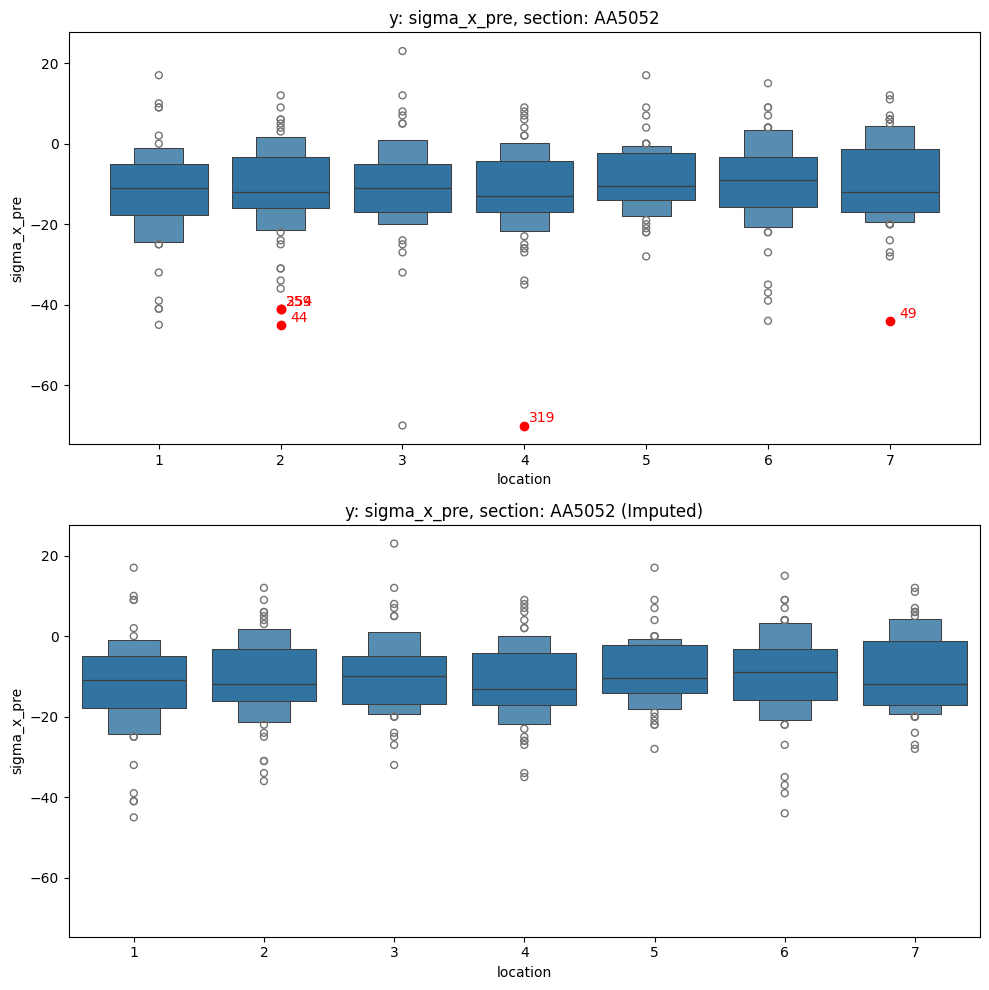

In [70]:
section = "AA5052"
y = "sigma_x_pre"
max_val = 150
min_val = -40
impute_idxs = [370]

# Filter data for specific section
filt = dfm["section"].isin([section])
idx_excel_col = "idx_excel_pre" if "pre" in y else "idx_excel_post"

# Identify rows with high residual stress in pre-weld data for further investigation
filt_val = (dfm[y] > max_val) | (dfm[y] < min_val)
dfm_outlier = dfm[filt & filt_val][[*default_cols, y, idx_excel_col]].sort_values(by=y)
display(dfm_outlier)

# Impute outlier values with median of respective location and section
for idx in impute_idxs:
    location = dfm.loc[idx, "location"]
    section = dfm.loc[idx, "section"]
    filt_idx = (
        (dfm["location"] == location)
        & (dfm["section"] == section)
        & (~dfm.index.isin(impute_idxs))
    )
    mean_val = dfm[filt_idx][y].mean()
    print(
        f"Imputing idx {idx} at location {location}, section {section} with mean value: {mean_val}"
    )
    dfm_imputed.loc[idx, y] = dfm[filt_idx][y].median()

# Plot boxenplot of pre-weld residual stress by location and section
filt = dfm["section"].isin([section])
fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharey=True)
sns.boxenplot(dfm[filt], x="location", y=y, ax=ax[0])
ax[0].plot(dfm_outlier["location"], dfm_outlier[y], "ro", label="Outliers")
for i, row in dfm_outlier.iterrows():
    ax[0].text(
        row["location"]+0.15,
        row[y],
        f"{row[idx_excel_col]}",
        color="red",
        fontsize=10,
        ha="center",
        va="bottom",
        clip_on=True,
    )
ax[0].set_title(f"y: {y}, section: {section}")
sns.boxenplot(dfm_imputed[filt], x="location", y=y, ax=ax[1])
ax[1].set_title(f"y: {y}, section: {section} (Imputed)")
plt.tight_layout()
plt.show()

# Function


In [71]:
def outlier(section, y, max_val, min_val, impute_idxs):
    # section = "AA5052"
    # y = "sigma_x_pre"
    # max_val = 150
    # min_val = -40
    # impute_idxs = [370]

    # Filter data for specific section
    filt = dfm["section"].isin([section])
    idx_excel_col = "idx_excel_pre" if "pre" in y else "idx_excel_post"

    # Identify rows with high residual stress in pre-weld data for further investigation
    filt_val = (dfm[y] > max_val) | (dfm[y] < min_val)
    dfm_outlier = dfm[filt & filt_val][[*default_cols, y, idx_excel_col]].sort_values(
        by=y
    )
    display(dfm_outlier)

    # Impute outlier values with median of respective location and section
    for idx in impute_idxs:
        location = dfm.loc[idx, "location"]
        section = dfm.loc[idx, "section"]
        filt_idx = (
            (dfm["location"] == location)
            & (dfm["section"] == section)
            & (~dfm.index.isin(impute_idxs))
        )
        mean_val = dfm[filt_idx][y].mean()
        print(
            f"Imputing idx {idx} at location {location}, section {section} with mean value: {mean_val}"
        )
        dfm_imputed.loc[idx, y] = dfm[filt_idx][y].median()

    # Plot boxenplot of pre-weld residual stress by location and section
    filt = dfm["section"].isin([section])
    fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharey=True)
    sns.boxenplot(dfm[filt], x="location", y=y, ax=ax[0])
    ax[0].plot(dfm_outlier["location"], dfm_outlier[y], "ro", label="Outliers")
    ax[0].set_title(f"y: {y}, section: {section}")
    for i, row in dfm_outlier.iterrows():
        ax[0].text(
            row["location"]+0.15,
            row[y],
            f"{row[idx_excel_col]}",
            color="red",
            fontsize=10,
            ha="center",
            va="bottom",
            clip_on=True,
        )
    sns.boxenplot(dfm_imputed[filt], x="location", y=y, ax=ax[1])
    ax[1].set_title(f"y: {y}, section: {section} (Imputed)")
    plt.tight_layout()
    plt.show()

# Outlier Removal and Imputation


,section,sample_no,location,sigma_x_pre,idx_excel_pre
370,AA5052,46,3,-70,319
6,AA5052,7,1,-45,44
817,AA5052,7,6,-44,49
36,AA5052,37,1,-41,254
51,AA5052,52,1,-41,359


Imputing idx 370 at location 3, section AA5052 with mean value: -9.69811320754717


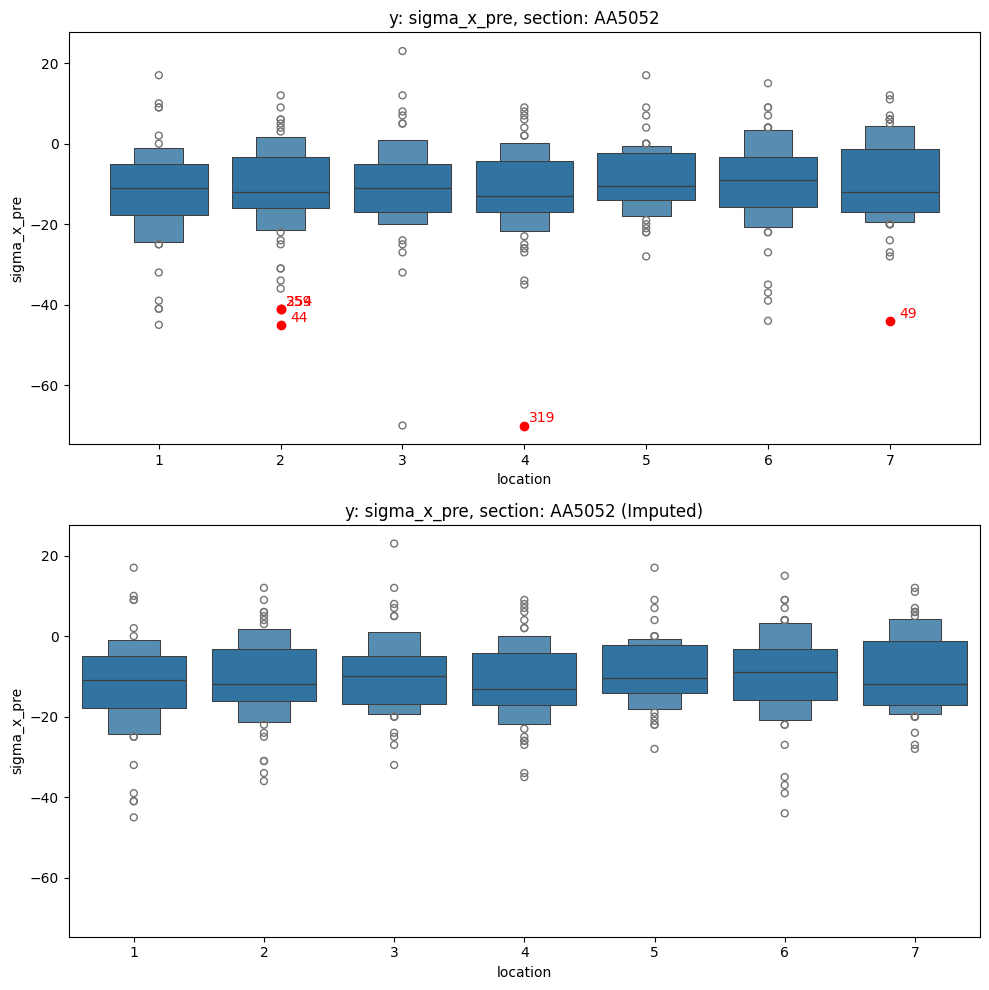

In [72]:
section = "AA5052"
y = "sigma_x_pre"
max_val = 150
min_val = -40
impute_idxs = [370]

outlier(section, y, max_val, min_val, impute_idxs)

,section,sample_no,location,sigma_x_pre,idx_excel_pre
745,AA6061,43,5,-109,300
554,AA6061,14,4,-92,96
227,AA6061,11,2,-85,73
747,AA6061,45,5,-83,314
217,AA6061,1,2,-79,3
392,AA6061,14,3,-78,95
875,AA6061,11,6,-77,77
566,AA6061,26,4,-76,180
723,AA6061,21,5,-73,146
270,AA6061,54,2,-72,374


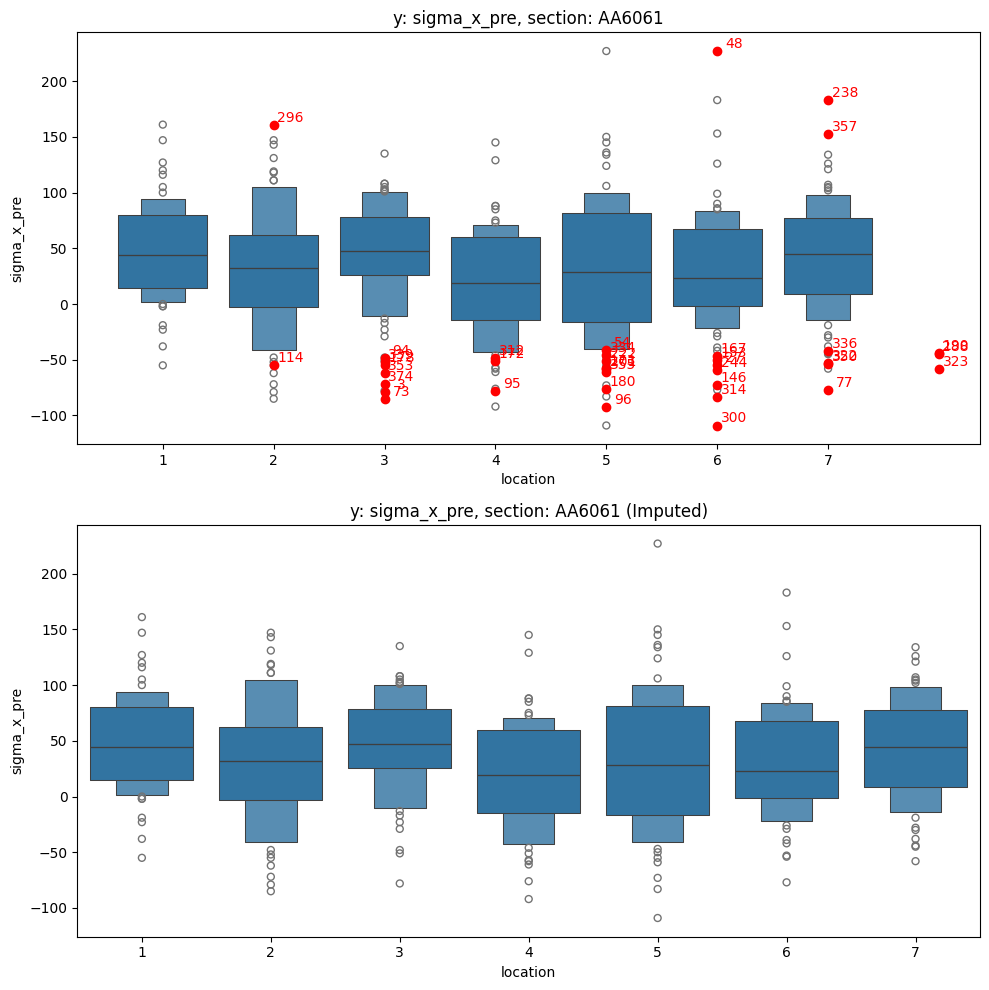

In [73]:
section = "AA6061"
y = "sigma_x_pre"
max_val = 150
min_val = -40
impute_idxs = []

outlier(section, y, max_val, min_val, impute_idxs)

,section,sample_no,location,sigma_x_post,idx_excel_post


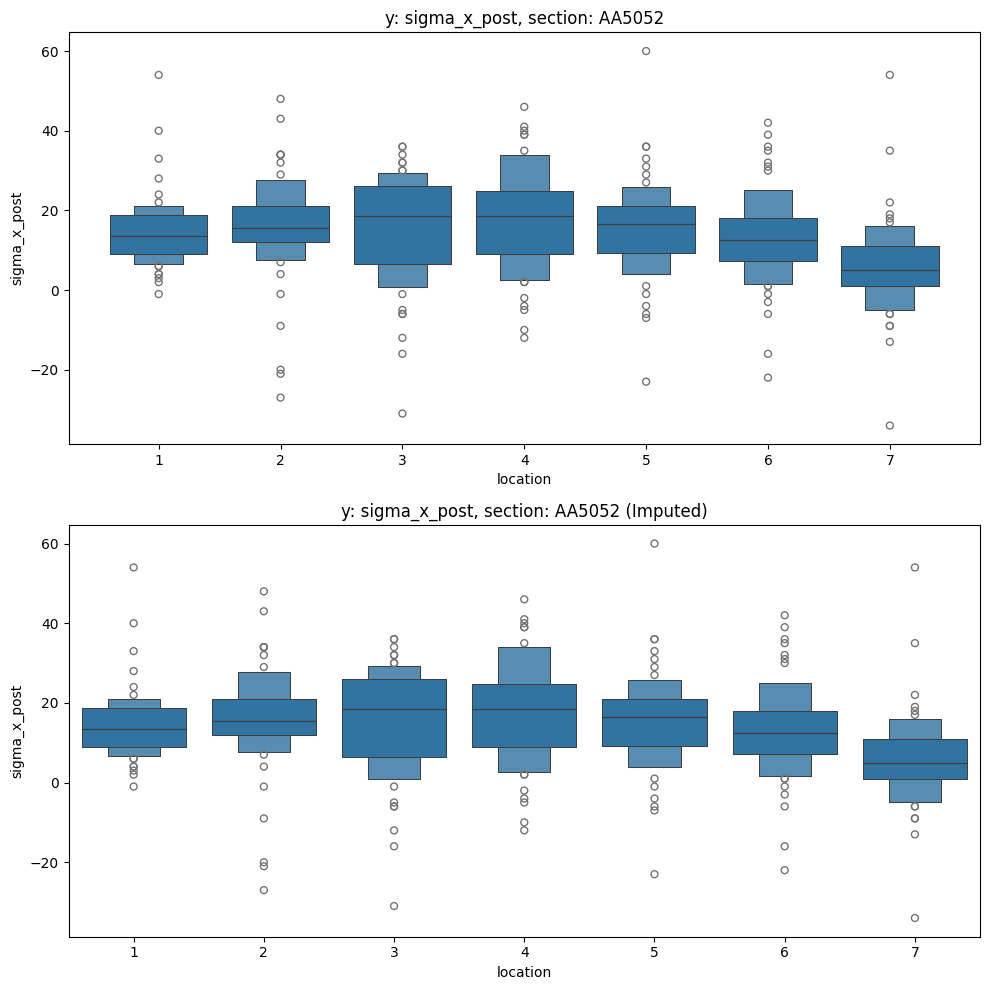

In [74]:
section = "AA5052"
y = "sigma_x_post"
max_val = 150
min_val = -40
impute_idxs = []

outlier(section, y, max_val, min_val, impute_idxs)

,section,sample_no,location,sigma_x_post,idx_excel_post
1039,AA6061,13,7,-122,272
1027,AA6061,1,7,-90,20
417,AA6061,39,3,-56,806
1066,AA6061,40,7,-54,839
889,AA6061,25,6,-52,521
407,AA6061,29,3,-44,596
878,AA6061,14,6,-44,290
563,AA6061,23,4,-41,473


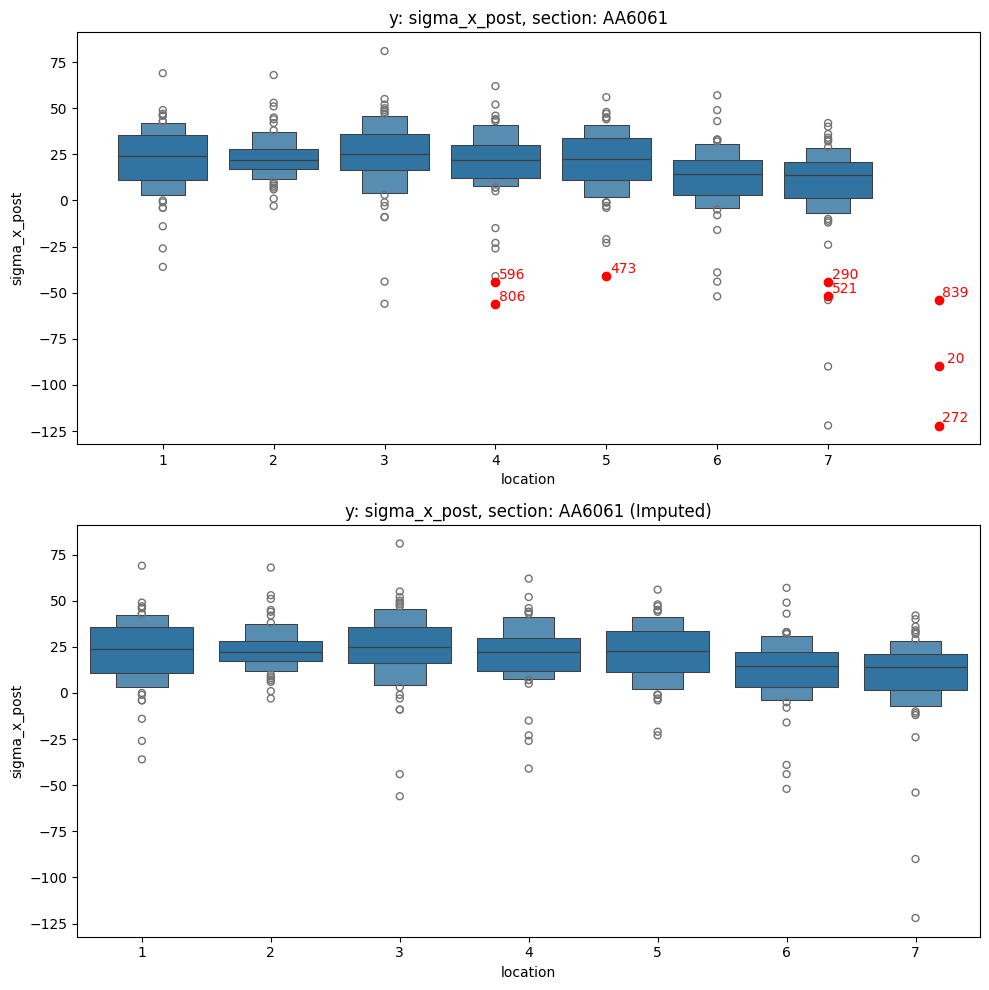

In [75]:
section = "AA6061"
y = "sigma_x_post"
max_val = 150
min_val = -40
impute_idxs = []

outlier(section, y, max_val, min_val, impute_idxs)

,section,sample_no,location,sigma_x_post,idx_excel_post


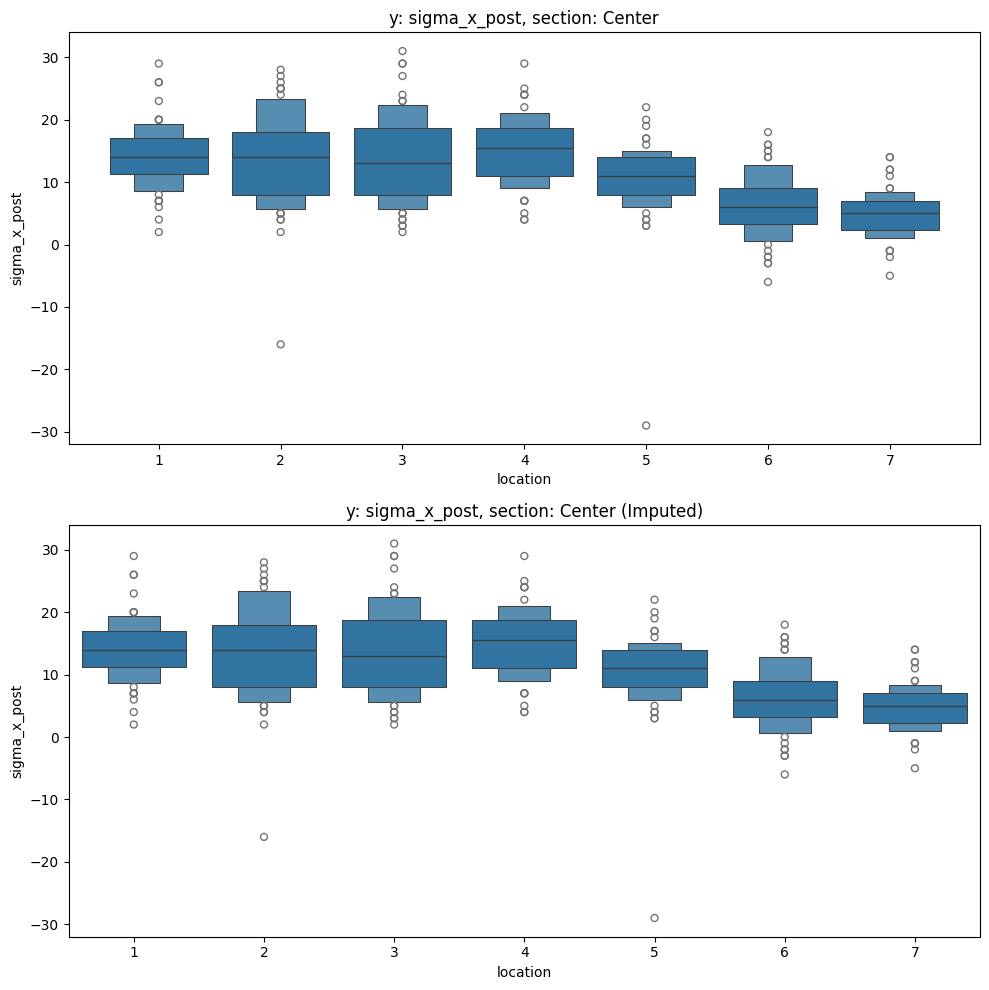

In [76]:
section = "Center"
y = "sigma_x_post"
max_val = 150
min_val = -40
impute_idxs = []

outlier(section, y, max_val, min_val, impute_idxs)

,section,sample_no,location,FWHM_pre,idx_excel_pre


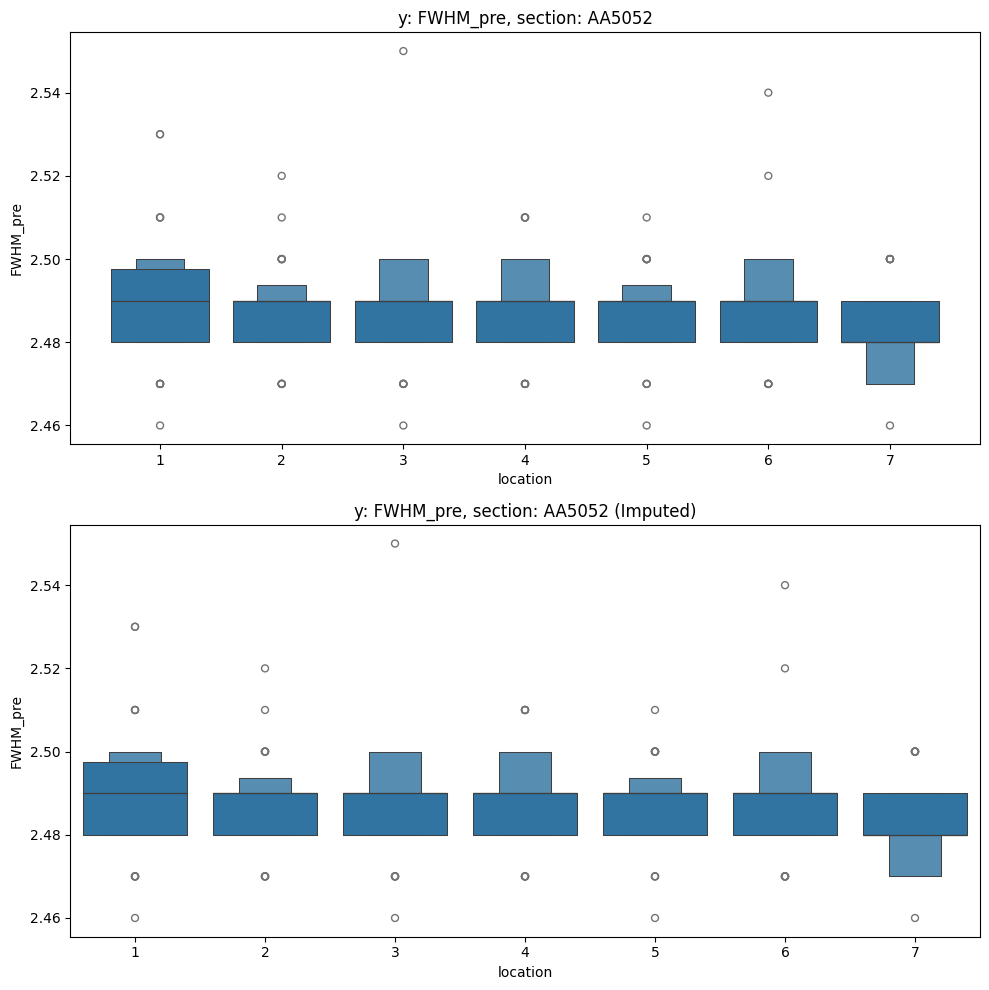

In [77]:
section = "AA5052"
y = "FWHM_pre"
max_val = 150
min_val = -40
impute_idxs = []

outlier(section, y, max_val, min_val, impute_idxs)

,section,sample_no,location,FWHM_pre,idx_excel_pre
101,AA6061,47,1,0.0,0


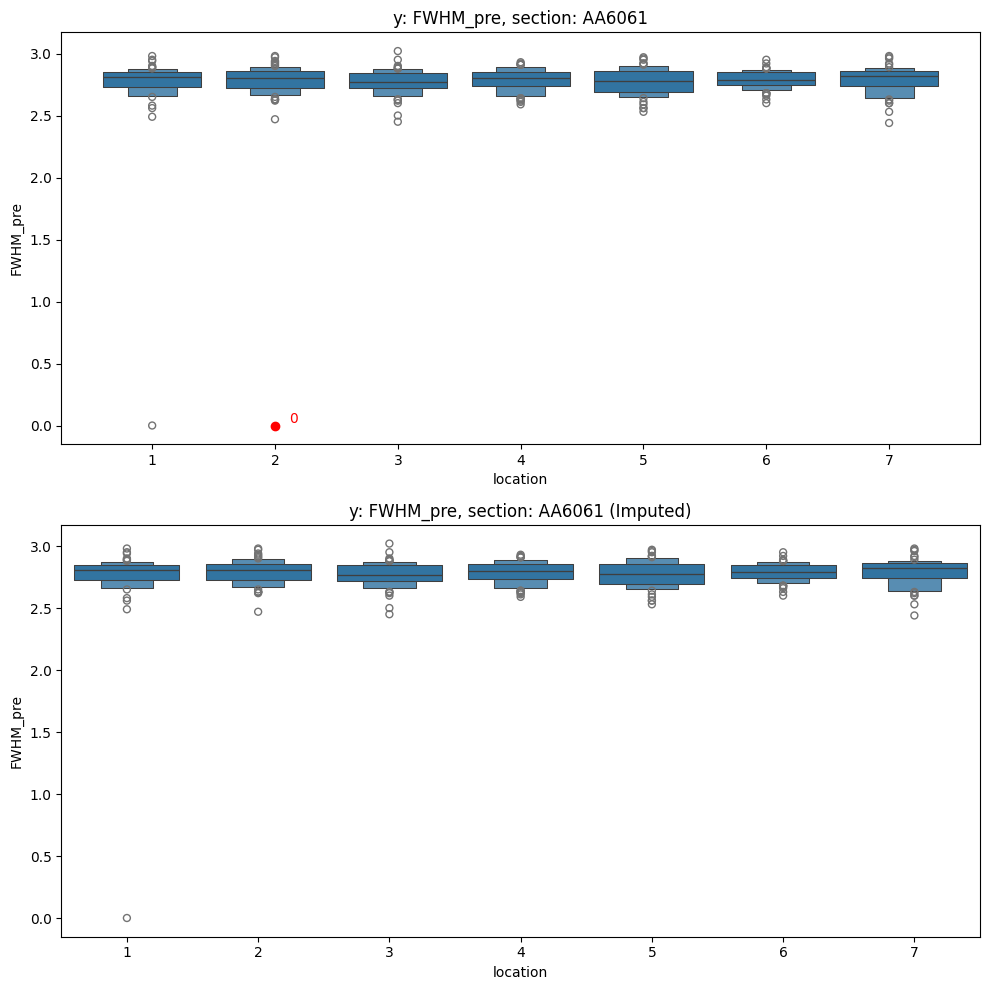

In [78]:
section = "AA6061"
y = "FWHM_pre"
max_val = 150
min_val = 1
impute_idxs = []

outlier(section, y, max_val, min_val, impute_idxs)

,section,sample_no,location,FWHM_post,idx_excel_post


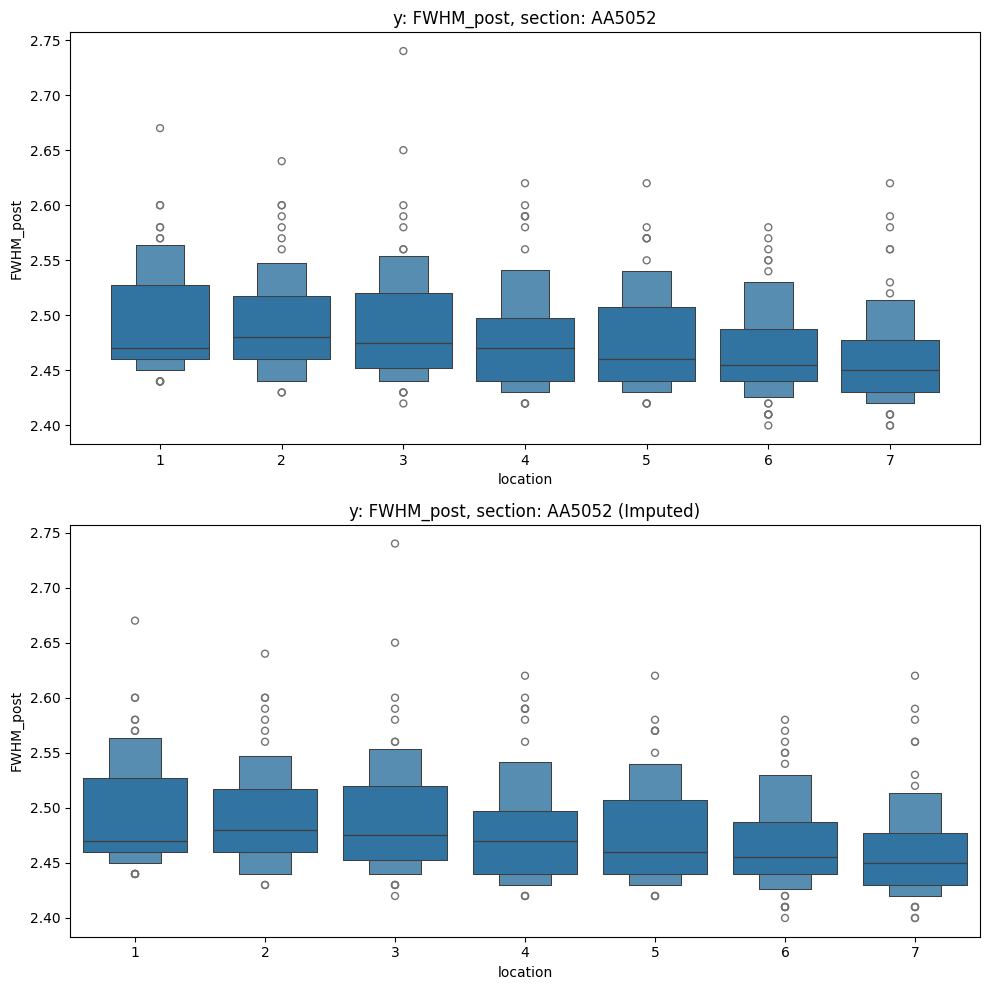

In [79]:
section = "AA5052"
y = "FWHM_post"
max_val = 150
min_val = 1
impute_idxs = []

outlier(section, y, max_val, min_val, impute_idxs)

,section,sample_no,location,FWHM_post,idx_excel_post
100,AA6061,47,1,0.0,0


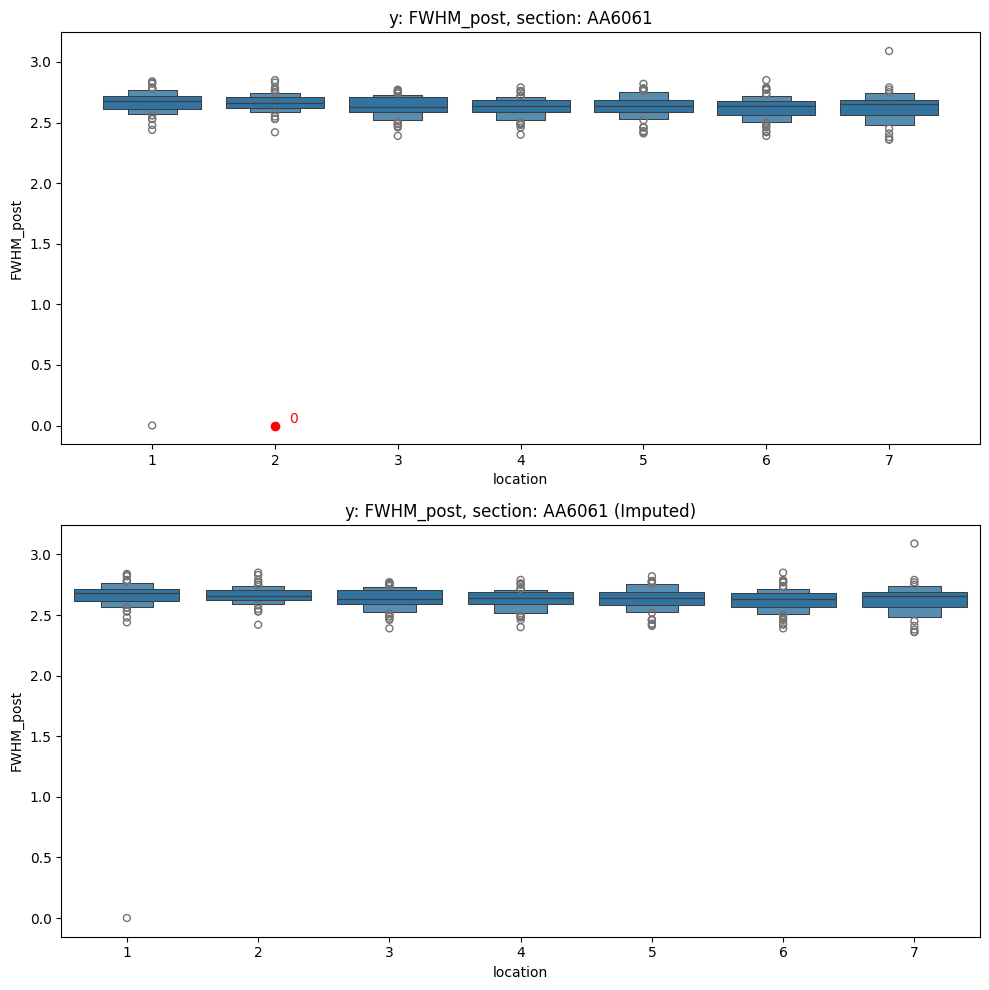

In [80]:
section = "AA6061"
y = "FWHM_post"
max_val = 150
min_val = 1
impute_idxs = []

outlier(section, y, max_val, min_val, impute_idxs)

,section,sample_no,location,FWHM_post,idx_excel_post


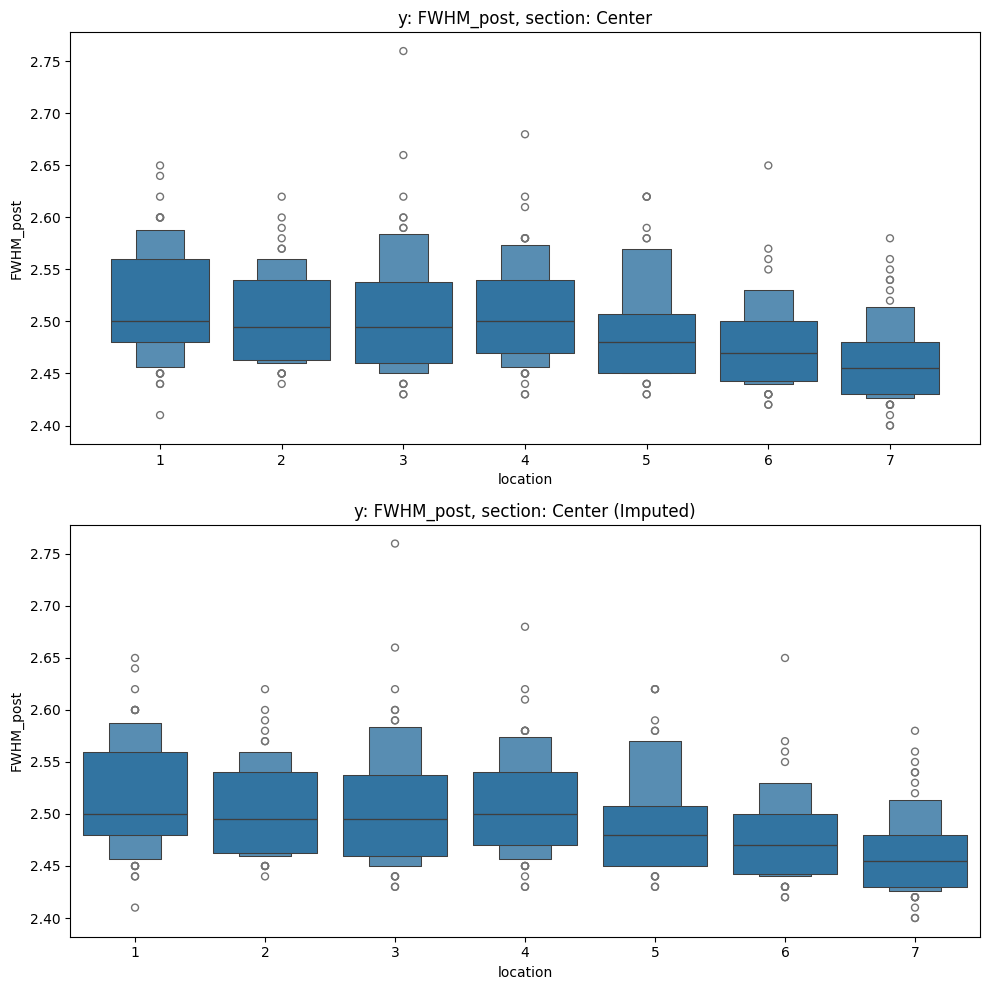

In [81]:
section = "Center"
y = "FWHM_post"
max_val = 150
min_val = 1
impute_idxs = []

outlier(section, y, max_val, min_val, impute_idxs)

In [82]:
dfm_imputed.to_excel("S04_residual_stress_imputed.xlsx", index=False)